In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data = pd.read_csv("final.csv", encoding="latin-1")
data["Industry_encoded"] = le.fit_transform(data['Industry'])
data["Industry"] = data["Industry"].astype("category")
data["cluster"] = data["cluster"].astype("category")
data = data.drop(columns=["Unnamed: 0"])
data.info()
# data.info()
# print(data.head)
# data = data.drop(columns=["cluster"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Yt.1M             911 non-null    float64 
 1   Industry          911 non-null    category
 2   MR                911 non-null    float64 
 3   TRC               911 non-null    float64 
 4   BAB               911 non-null    float64 
 5   EV                911 non-null    float64 
 6   P/B               911 non-null    float64 
 7   PSR               911 non-null    float64 
 8   ROA               911 non-null    float64 
 9   C/A               911 non-null    float64 
 10  D/A               911 non-null    float64 
 11  PG                911 non-null    float64 
 12  AG                911 non-null    float64 
 13  cluster           911 non-null    category
 14  Industry_encoded  911 non-null    int32   
dtypes: category(2), float64(12), int32(1)
memory usage: 92.4 KB


In [97]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from shap import TreeExplainer
# Set up 5-Fold cross-validation


In [123]:
def compute_aggregate(data, cat_columns, agg_keys, numeric_columns, agg_methods):
    stats_df_list = []
    cat_colums_str = "-".join(agg_keys)
    for numeric_col in numeric_columns:
        stats_df = data.groupby(agg_keys)[numeric_col].agg(agg_methods).rename(
            columns={agg_method:f"{cat_colums_str}-{numeric_col}-{agg_method}" for agg_method in agg_methods}
        )
        stats_df_list += [stats_df]
    stats_df = stats_df_list[0]
    for stats_df_ in stats_df_list[1:]:
        stats_df = stats_df.merge(stats_df_, on=agg_keys, how='left')
    return stats_df

def get_stats_df(train_data):
    cat_columns = ["Industry","cluster"]
    numeric_columns = ['MR', 'TRC', 'BAB', 'EV', 'P/B', 'PSR', 'ROA', 'C/A', 'D/A', 'PG', 'AG']
    agg_methods = ["mean","median","max"]
    i_stats_df = compute_aggregate(train_data,  cat_columns, ["Industry"], numeric_columns, agg_methods).reset_index()
    c_stats_df = compute_aggregate(train_data,  cat_columns, ["cluster"], numeric_columns, agg_methods).reset_index()
    ic_stats_df = compute_aggregate(train_data, cat_columns,  cat_columns, numeric_columns, agg_methods).reset_index()
    # final_stats_df = i_stats_df.merge(c_stats_df, how='outer')
    final_stats_df = ic_stats_df
    for col in i_stats_df.columns:
        if col=="Industry":
            continue
        final_stats_df[col] = final_stats_df["Industry"].map(i_stats_df.set_index('Industry')[col])
    for col in c_stats_df.columns:
        if col=="cluster":
            continue
        final_stats_df[col] = final_stats_df["cluster"].map(c_stats_df.set_index('cluster')[col])
    
    
    # print(final_stats_df.head())
    # final_stats_df = final_stats_df.merge(c_stats_df, on=["cluster"], how='outer')
    return final_stats_df

In [124]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Loop over each fold for cross-validation
fold_metrics = []
fold_counter = 1
X = data.drop(columns=["Yt.1M"])
y = data["Yt.1M"]
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}
cat_features = ["Industry","cluster"]
shap_summary_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # get industry-based values
    # Grouped stats inside CV
    stats_df = get_stats_df(X_train)
    X_train = X_train.merge(stats_df, on=cat_features, how='left')
    X_test = X_test.merge(stats_df, on=cat_features, how='left')
    
    
    # Initialize the XGBoost regressor.
    # n_estimators, learning_rate, and max_depth can be tuned further.
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000
    )
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    fold_metrics.append({
    'Fold': fold_counter,
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae
    })
    explainer = TreeExplainer(model, feature_perturbation="tree_path_dependent")
    shap_values = explainer(X_train)
    shap_importance = np.abs(shap_values.values).mean(axis=0)
    fold_summary = pd.DataFrame({
        "feature": X_train.columns,
        f"importance_fold_{fold_counter}": shap_importance
    })
    shap_summary_list += [fold_summary]
    # Output feature importances for the current fold
    # print(f"\nFold {fold_counter} Feature Importances:")
    # print(model.feature_importances_)
    # Output performance metrics for the current fold
    print(f"Fold {fold_counter} -- MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    fold_counter += 1

Fold 1 -- MSE: 0.0149, RMSE: 0.1219, MAE: 0.0778
Fold 2 -- MSE: 0.0217, RMSE: 0.1475, MAE: 0.0837
Fold 3 -- MSE: 0.0233, RMSE: 0.1528, MAE: 0.0817
Fold 4 -- MSE: 0.0158, RMSE: 0.1258, MAE: 0.0865
Fold 5 -- MSE: 0.0124, RMSE: 0.1111, MAE: 0.0779


In [127]:
shap_df = shap_summary_list[0]
for df in shap_summary_list[1:]:
    shap_df = shap_df.merge(df, on="feature")

# Compute average importance
importance_cols = [col for col in shap_df.columns if col.startswith("importance_fold")]
shap_df["mean_importance"] = shap_df[importance_cols].mean(axis=1)
shap_df = shap_df.sort_values(by="mean_importance")
top_features = shap_df.head(10)["feature"].values

In [128]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Loop over each fold for cross-validation
fold_metrics = []
fold_counter = 1
X = data.drop(columns=["Yt.1M"])
y = data["Yt.1M"]
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}
cat_features = ["Industry","cluster"]
used_cat_features = [cf for cf in cat_features if cf in top_features]
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    stats_df = get_stats_df(X_train)
    X_train = X_train.merge(stats_df, on=cat_features, how='left')
    X_test = X_test.merge(stats_df, on=cat_features, how='left')
    
    X_train, X_test = X_train[top_features], X_test[top_features]
    # Initialize the XGBoost regressor.
    # n_estimators, learning_rate, and max_depth can be tuned further.
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=used_cat_features)
    val_data = lgb.Dataset(X_test, label=y_test, categorical_feature=used_cat_features)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000
    )
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    fold_metrics.append({
    'Fold': fold_counter,
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae
    })
    print(f"Fold {fold_counter} -- MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    fold_counter += 1

Fold 1 -- MSE: 0.0111, RMSE: 0.1052, MAE: 0.0696
Fold 2 -- MSE: 0.0229, RMSE: 0.1515, MAE: 0.0846
Fold 3 -- MSE: 0.0194, RMSE: 0.1392, MAE: 0.0744
Fold 4 -- MSE: 0.0139, RMSE: 0.1180, MAE: 0.0782
Fold 5 -- MSE: 0.0103, RMSE: 0.1016, MAE: 0.0663


In [129]:
xgb.plot_importance(model, importance_type="gain")
plt.title("Feature Importance")
plt.show()

NameError: name 'xgb' is not defined

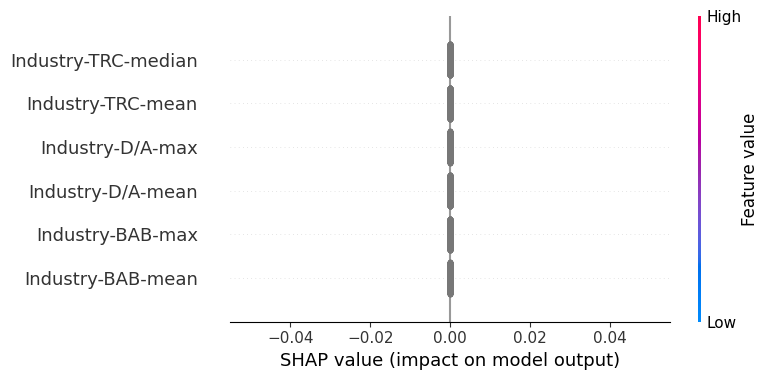

In [107]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

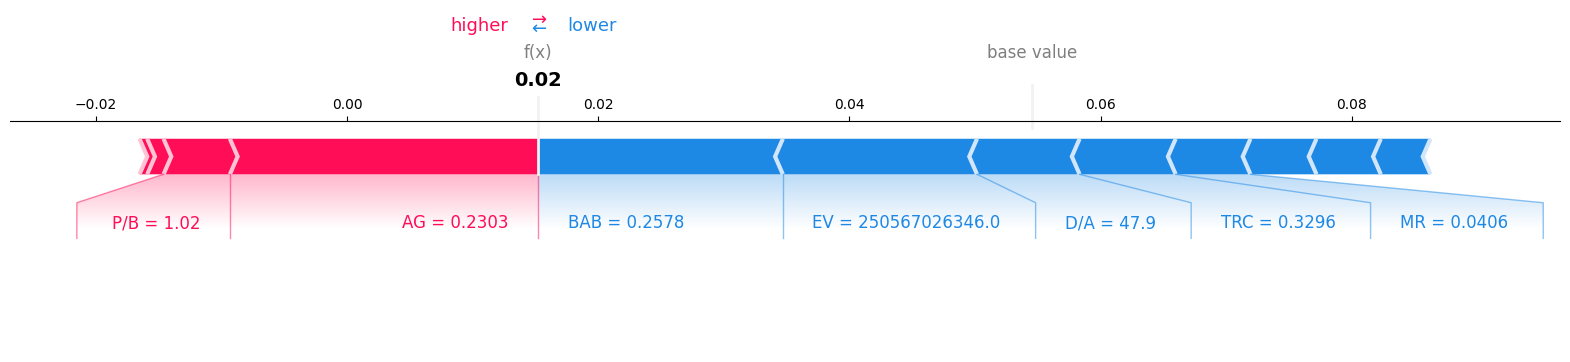

In [13]:
shap.plots.force(shap_values[0],matplotlib=True)
print(

In [10]:
cat_features = ["Industry","cluster"]
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    }
    fold_rmse_list = []
    for train_index, test_index in kf.split(X):
        train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
        val_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, val_data],
            num_boost_round=5000
        )
        # Make predictions on the test data
        y_pred = model.predict(X_test)
        # Compute evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        fold_rmse_list += [rmse]
    return np.asanyarray(fold_rmse_list).mean()

In [11]:
import optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)  # you can increase n_trials

[I 2025-04-13 07:05:18,352] A new study created in memory with name: no-name-5afbd55a-b43f-4914-bf50-b06e4a678790
[I 2025-04-13 07:05:33,322] Trial 0 finished with value: 0.11054734415184922 and parameters: {'learning_rate': 0.06616224854449378, 'num_leaves': 74, 'min_child_samples': 98, 'feature_fraction': 0.6679385761586292, 'bagging_fraction': 0.6799933058493502, 'bagging_freq': 10}. Best is trial 0 with value: 0.11054734415184922.
[I 2025-04-13 07:05:52,553] Trial 1 finished with value: 0.11054734415184922 and parameters: {'learning_rate': 0.024693489673105237, 'num_leaves': 102, 'min_child_samples': 26, 'feature_fraction': 0.7786189030811749, 'bagging_fraction': 0.6421964514451445, 'bagging_freq': 5}. Best is trial 0 with value: 0.11054734415184922.
[I 2025-04-13 07:06:14,562] Trial 2 finished with value: 0.11054734415184922 and parameters: {'learning_rate': 0.061365267700147406, 'num_leaves': 62, 'min_child_samples': 11, 'feature_fraction': 0.8586242503238244, 'bagging_fraction':

KeyboardInterrupt: 

In [56]:
# optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()